In [1]:
import dataset
from tensorflow import estimator as tf_estimator
import models.losses as losses
import tensorflow as tf
from models.metrics import *
import models.cnn_autoencoder_model as cnnmodel
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
unet_model = tf.keras.models.load_model('saved_model/unet_model', custom_objects={
    'masked_weighted_cross_entropy_with_logits': losses.weighted_cross_entropy_with_logits_with_masked_class,
    'AUCWithMaskedClass': AUCWithMaskedClass(with_logits=True)
})

In [3]:
from seggradcam.seggradcam import SegGradCAM, SuperRoI, ClassRoI, PixelRoI, BiasRoI
from seggradcam.visualize_sgc import SegGradCAMplot

In [4]:
from matplotlib import colors
import matplotlib.pyplot as plt
hparams = {
    # 数据路径
    'train_path': '../dataset/next_day_wildfire_spread_train*',
    'eval_path': '../dataset/next_day_wildfire_spread_eval*',
    'test_path': '../dataset/next_day_wildfire_spread_test*',
    
    # 特征
    'input_features': ['elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn',
                  'tmmx', 'vs', 'erc', 'population', 'PrevFireMask'],
    'output_features': ['FireMask'],
    
    # 方位通道
    'azimuth_in_channel': None,
    'azimuth_out_channel': None,
    
    # 数据和模型参数
    'data_sample_size': 64,
    'sample_size': 32,
    'output_sample_size': 32,
    'batch_size': 128,
    'shuffle': False,
    'shuffle_buffer_size': 10000,
    'compression_type': None,
    'input_sequence_length': 1,
    'output_sequence_length': 1,
    'repeat': False,
    'clip_and_normalize': True,
    'clip_and_rescale': False,
    
    # 数据增强
    'random_flip': False,
    'random_rotate': False,
    'random_crop': False,
    'center_crop': True,
    
    # 其他参数
    'downsample_threshold': 0.0,
    'binarize_output': True
}

test_dataset = dataset.make_dataset(
    hparams,
    mode = tf_estimator.ModeKeys.PREDICT
)
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask',
  'Predict\nmask',
]
# Number of rows of data samples to plot
n_rows = 10 
# Number of data variables
n_features = 12
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

inputs, labels = next(iter(test_dataset))


cls = 0
image =  inputs[1]
prop_from_layer = unet_model.layers[-1].name
prop_to_layer = 'conv2d_8'

## A. Seg-Grad-CAM for a pixel

logits_output shape: (1, 32, 32, 1)
self.cls: 0
self.roi.roi shape: (32, 32)
Shape of self.A: (32, 32, 16)
Shape of self.alpha_c: (16,)
Shape of cam: (32, 32)
Shape of all_cam: (32, 32, 16)


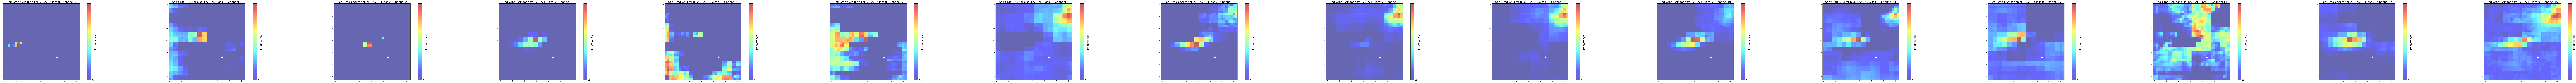

In [7]:
# create a SegGradCAM object
pixsgc = SegGradCAM(unet_model, image, cls,  prop_to_layer,prop_from_layer, roi=PixelRoI(22,22,image),
                 normalize=True, abs_w=False, posit_w=False)
# compute SegGradCAM
pixsgc.SGC()
# create an object with plotting functionality
plotter = SegGradCAMplot(pixsgc, unet_model, None, None)
# plot explanations on 1 picture
plotter.explainPixel()

## B. Seg-Grad-CAM for a class

1/1 [==============================] - 0s 22ms/step
Shape of RoI:  (32, 32)
Lengths of i and j index lists: 7 7
logits_output shape: (1, 32, 32, 1)
self.cls: 0
self.roi.roi shape: (32, 32)
Shape of self.A: (32, 32, 16)
Shape of self.alpha_c: (16,)
Shape of cam: (32, 32)
Shape of all_cam: (32, 32, 16)


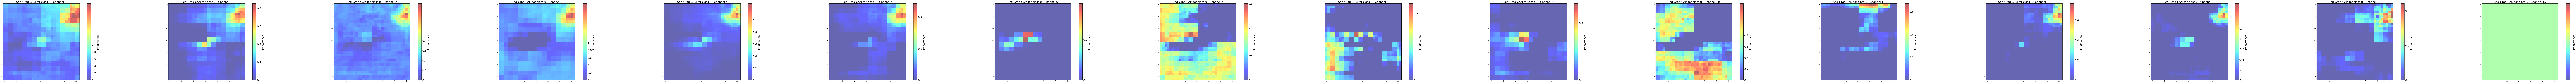

In [10]:
clsroi = ClassRoI(unet_model,image,cls)
clssgc = SegGradCAM(unet_model, image, cls,  prop_to_layer,prop_from_layer, roi=clsroi,
                 normalize=True, abs_w=False, posit_w=False)
clssgc.SGC()
clsplotter = SegGradCAMplot(clssgc, unet_model, None, None)
clsplotter.explainClass()